# Lesson 19 : DDPM and Dropout

[lesson 19](https://course.fast.ai/Lessons/lesson19.html)

[YouTube](https://youtu.be/ItyO8s48zdc)



## Dropout

* A student (Christopher Thomas) broke Jeremy's record using dropout layers. 

* Dropout is a regularization technique for neural networks that prevents overfitting, we have discussed before in part 1. 

* He added an implementation to end of notebook 14 but he will be using Pytorch's implementation in the future. 

* See end of my Lesson18 notes for model with dropout.

## Imports

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *
from minai.resnet import *
from minai.augment import *
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)


## DDPM from scratch

Notebook 15 (Tanishq) and Notebook 17 (Jermey's version).   I will mostly be following Jeremy's version here.

* Denoising Diffusion Probabilistic Models ([DDPM](https://arxiv.org/abs/2006.11239)) is a generative model that can generate high-quality images.
* We discussed this in general terms at the beginning of Part 2. 
* Details and specifics are derived from variational inference and other techniques, given in the paper.
* The neural network module that is used for $\mathbf{\mu}_\theta(\mathbf{x}_t, t)$ to is a U-net, which we will cover in future lessons, but it is a U-shaped network with skip connections.


### Load and prep data set

Note that Jeremy and Tanishq do this slightly differently.   Tanish resamples to 32 x 32, while Jeremy pads

In [2]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

xl,yl = 'image','label'
# resize to 32 by 32 by padding and convert to tensor
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

Set up batches

In [3]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

## The Idea

![Probablistic graphical model](images/DDPM.png)

Denoising Diffusion Probabilistic Models (DDPM) are generative models that progressively refine noisy data into meaningful structures, such as generating images from noise.


* Imagine staring at a chaotic cloud of noise. If you squint just enough, you might start to perceive a faint outline of something familiar, perhaps a face, a tree, or a distant landscape. Over time, the noise fades, and a clear image gradually takes form. This step-by-step refinement mirrors how DDPM models the process of image generation.

* This reverse process $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_t)$ describes how images are reconstructed step-by-step from noisy latent variables $\mathbf{x}_t$ to the final clear image $\mathbf{x}_0$. Each transition is modeled as a Gaussian distribution:

$$
p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t}; \mathbf{\mu}_\theta(\mathbf{x}_t, t), \mathbf{\Sigma_{\theta}}(\mathbf{x}_t, t))
$$ 

* Variational inference is used to approximate the true distribution of latent variables. The model learns to infer the parameters $\mathbf{\mu}_\theta$ and $\mathbf{\Sigma_\theta}$ by minimizing the difference (KL divergence) between the approximate and true posterior distributions.

* This can be quite complicated, but the paper makes multiple simplifications to make this tractable. The most important of these are: 

   * The approximate posterior ('forward process' $q(\mathbf{x}_t|\mathbf{x}_{t-1})$) is assumed to be *fixed* to function that gradually adds noise according to a variance schedule $\beta_t$:

   $$
    q(\mathbf{x}_t|\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t}; \sqrt{1-\beta_t}\mathbf{x}_{t-1}, \beta_t \mathbf{I})
   $$

   * In the reverse process, $\Sigma_{\theta}$ is assumed to be  $\sigma_t^2 \mathbf{I}$, where $\sigma_t$ is an untrained time dependant constant.

* The paper notes that forward process can be expressed compactly for arbitrary time $t$ in closed form, allowing us to compute noise addition efficiently:


$$
q(\mathbf{x}_t|\mathbf{x}_0) = \prod_{t=1}^{t} q(\mathbf{x}_t|\mathbf{x}_{t-1})  = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I})
$$

Where:

$$
\begin{align*}
\alpha_t &= 1 - \beta_t \\
\bar{\alpha}_t &= \prod_{i=1}^{t} \alpha_i
\end{align*}
$$



## Forward process 

In [5]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

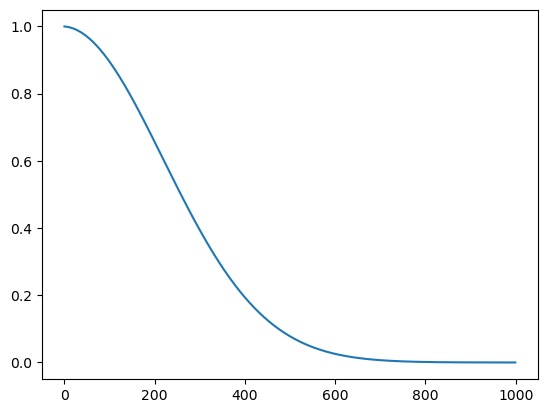

In [6]:
plt.plot(alphabar)

Remember:
$$
q_{\theta}(\mathbf{x}_t|\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I})
$$

For small t, hardly any noise has been added, and for t -> 1, its all noise 

We can also write this as:

$$
x_t = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}z_t
$$
    
Where $z_t \sim \mathcal{N}(0, \mathbf{I})$

To implement they define `noisify` which selects a random timestep and adds noise to the image.
Since this will be used to create the training data, this function will create the data and the labels from an image: 
 - data is the noisy image and the timestep (a tuple)
 - The label is the noise that was added.  

In [7]:
# added n_steps argument 
def noisify(x0, ᾱ, n_steps):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

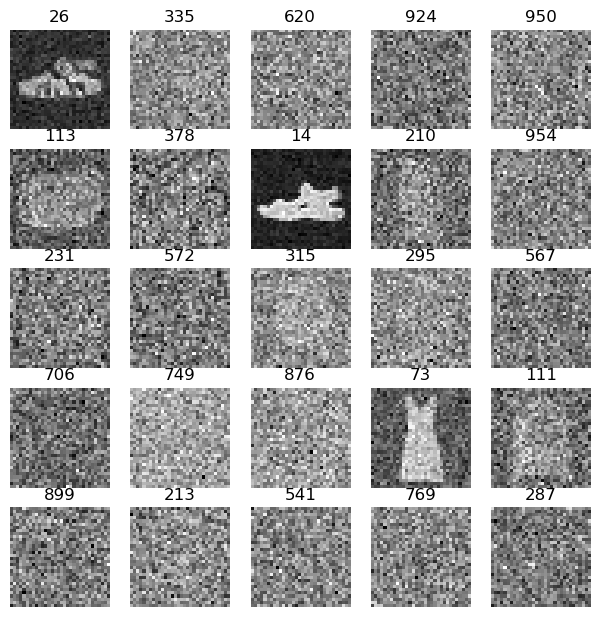

In [8]:
(xt,t),ε = noisify(xb[:25],alphabar, n_steps)
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

### Reverse process

The reverse process is at the heart of DDPM. The goal is to sample new images from the model.

* To sample from $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t})$, we need $\mathbf{\mu}_{\theta}(\mathbf{x}_t, t)$.   How can we get $\mu$ from our model that will be trained to predict the noise ($\epsilon$)? 

* Remember that $\mu$ is the mean of the next image in the denoising process, given the current image.  What target should we have for this? That is, in the forward process, what is the mean of the distribution of $\mathbf{x}_{t-1}$ *given* $\mathbf{x}_{t}$ and the orignal image $x_0$ ?  This distribution is:

$$
q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)= q(\mathbf{x}_{t} | \mathbf{x}_{t-1}) \frac{q(\mathbf{x}_{t-1} | \mathbf{x}_0)}{q(\mathbf{x}_{t} | \mathbf{x}_0)}  
$$

In the paper this target is justified using variational inference. 

* The authors of the paper derive an expression for the mean of this distrubtion, $\tilde{\mu}$, which is our target for $\mathbf{\mu}$. It is given in equation 7:
$$
\tilde{\mathbf{\mu}}(\mathbf{x}_t, \mathbf{x}_0) =  
\frac{\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_t}\mathbf{x}_0 + \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}\mathbf{x}_t
$$ 
(Equation 7)

* They then use the forward process to substitute $x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \sqrt{1-\bar{\alpha}_t}\mathbf{\epsilon})$ into the above equation and with some algebra we get the target in terms of $x_t$ and $\epsilon$:

$$
\tilde{\mathbf{\mu}} = \frac{1}{\sqrt{\bar{\alpha}_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\mathbf{\epsilon}  \right)
$$

* This is what $\mathbf{\mu}_\theta(\mathbf{x}_t,t)$ must predict.  Since $\mathbf{x}_t$ is an input to the model, we can instead reparametrize the model to predict $\epsilon$ instead.   
$$
\mathbf{\mu}_{\theta}(\mathbf{x}_t, t) = \frac{1}{\sqrt{\bar{\alpha}_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(\mathbf{x}_t,t)  \right)
$$

* This finally relates  $\epsilon$, what the model will be trained to predict and $\mu$, the mean of the predicted distribution for $x_{t-1}$ given $x_t$. 

* To sample then from $p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t})$, we can then use the following formula (Algorithm 2 in the paper)

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\bar{\alpha}_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(\mathbf{x}_t,t)  \right) + \sigma_t \mathbf{z}
$$

where $\mathbf{z}$ is a sample from a standard normal distribution.

In the model here we use $\sigma_t = \sqrt{\beta_t}$, which is (one option) from the paper.  

Here is the code that implements this, given the model for $\epsilon$ as the first argument 

NOTE: The method in the notebooks intepolates between removing all the noise and the noisy image and appears to be different then Algorithm 2 in the paper.   But it is not. It uses  $x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \sqrt{1-\bar{\alpha}_t}\mathbf{\epsilon})$ to predict the result of removing all the noise, and then uses uses Equation 7 to find $\mathbf{\mu}$.  But we saw that through some algebra that this can be transformed to the form in Algorithm 2.   I don't know why they used this more complicated form. 

In [ ]:
@torch.no_grad()
def old_sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)  # x_T 
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long) # make it look like a batch
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        # attempt to remove all the noise, see page 3 of paper just before equation 9. 
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        # interpolate between original noisy image and the denoised image, then add some more noise.. See equation 7? 
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

# Alternative version. Algorithm 2 from the paper
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)  # x_T 
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long) # make it look like a batch
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        b̄_t = 1 - alphabar[t]
        x_t = ((x_t -(1- alpha[t])/ b̄_t.sqrt() * model((x_t, t_batch)))/alpha[t].sqrt()) + sigma[t]*z
        preds.append(x_t.cpu())
    return preds



To do the training in the learner framework, use use a callback to create the target noise and the input tuple (noisy image and timestep). 
We also add the sample method for convenience.

In [22]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ, self.n_steps)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

## The model 

* As stated above the mode is a U-net, to be discussed (I believe) in lesson 23.  

* "The DDPM is a U-net with some modern tricks like using attention" - Notebook 15

* But like all models, it is a neural network with parameters $\theta$ that we want to learn.  It is a universal function approximator mapping from input to output!


We just grab it from Hugging face:

In [11]:
from diffusers import UNet2DModel

model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

Except we will want to modify it to use in our Learner, so we just subclass it and adjust the forward method to unpack the tuple (image and noise) and then use 'sample' which extracts the hidden states output from the last layer of the model.   This is a Hugging face thing, the UNet returns a dataclass that has one field, 'sample' of type torch.Tensor.  We want to return the tensor itself.


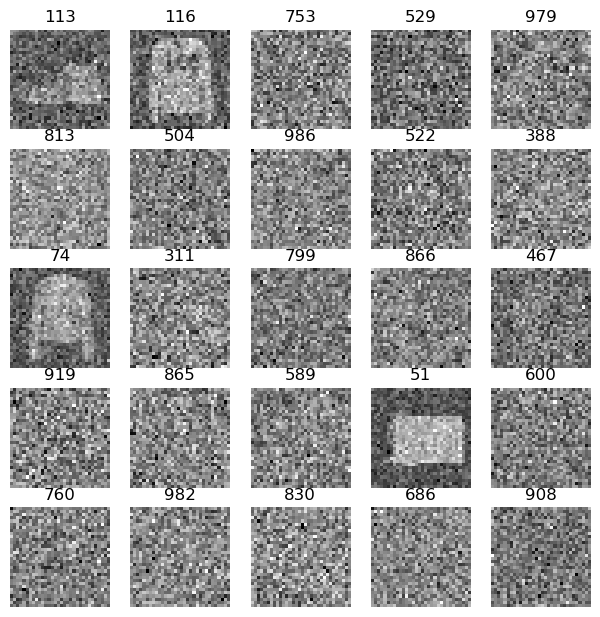

In [12]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)



Training

In [13]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)


# initialize weights
# This comes in at the end of the lecture. The default model initialization is just the default PyTorch initialization.
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()


init_ddpm(model)

loss,epoch,train
0.149,0,train
0.025,0,eval
0.023,1,train
0.022,1,eval
0.021,2,train
0.019,2,eval
0.019,3,train
0.019,3,eval
0.017,4,train
0.018,4,eval


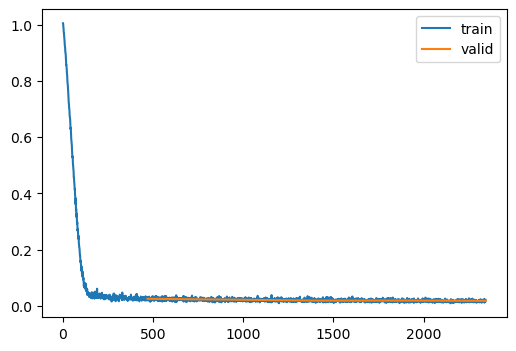

In [ ]:
opt_func = partial(optim.Adam, eps=1e-5)
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)
#learn.fit(epochs)

This takes about 6 minuts on my GPU

In [18]:
mdl_path = Path('models')
#torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')


In [19]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

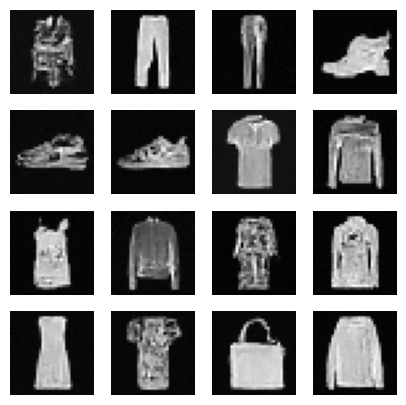

In [23]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
show_images(samples[-1], figsize=(5,5))

In [24]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML

fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Using matplotlib backend: <object object at 0x7f2289269a90>


QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


As noted in the lesson, the steps taken are only toward the end as most of the early steps are indisguishable from noise